* penalize incorrect action
* penalize revisiting states

In [1]:
import random
import copy
from collections import namedtuple, deque
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
from gym import spaces

In [2]:
class Board:
    def __init__(self, flasks: List[List[int]], num_color: int, max_length: int, empty: int = 2):
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.flasks = np.full((self.tubes, self.max_length), -1, dtype=np.int16)
        self.flasks[:self.num_color, :self.max_length] = flasks[:-empty]
        self.idx = np.zeros(self.tubes, dtype=np.uint16)
        self.idx[:self.num_color] = self.max_length
        self.actions = []
        self.states = set()

    def __str__(self):
        return str(self.flasks)

    def __repr__(self):
        return str(self.flasks)

    def __iter__(self):
        return iter(self.flasks)

    def __len__(self):
        return len(self.flasks)

    def __getitem__(self, item):
        return self.flasks[item]

    def grid_to_state(self) -> List[List[int]]:
        state = []
        for r in self:
            state.append([])
            for c in r:
                if c != -1:
                    state[-1].append(c)
        return state

    def state_to_grid(self, state: List[List[int]]):
        self.flasks.fill(-1)
        self.idx.fill(0)
        for i, r in enumerate(state):
            self.idx[i] = len(r)
            for j, c in enumerate(r):
                self.flasks[i][j] = c

    def is_flask_full(self, i: int) -> bool:
        return self.idx[i] == self.max_length

    def is_flask_empty(self, i: int) -> bool:
        return self.idx[i] == 0

    def has_one_color(self, i: int) -> bool:
        return (self.flasks[i] == self.flasks[i][0]).all()

    def is_flask_solved(self, i: int) -> bool:
        if self.is_flask_empty(i) or (self.is_flask_full(i) and self.has_one_color(i)):
            return True
        return False

    def top(self, i: int) -> int:
        return self.flasks[i][self.idx[i]-1]

    def pop(self, i: int) -> int:
        ball = self.flasks[i][self.idx[i]-1]
        self.flasks[i][self.idx[i] - 1] = -1
        self.idx[i] -= 1
        return ball

    def push(self, i: int, ball: int):
        self.flasks[i][self.idx[i]] = ball
        self.idx[i] += 1

    def is_push_allowed(self, i: int, ball: int) -> bool:
        if self.is_flask_empty(i) or (self.top(i) == ball and not self.is_flask_full(i)):
            return True
        return False

    def is_invalid_init_state(self) -> bool:
        return any(self.is_flask_full(i) and self.has_one_color(i) for i in range(self.tubes))

    def is_solved(self) -> bool:
        return all(self.is_flask_solved(i) for i in range(self.tubes))

    def is_deadend(self) -> bool:
        return not self.is_solved() and not self.valid_actions()

    def reward(self) -> int:
        if self.is_solved():
            return 100
        if self.is_deadend():
            return -100
        return -1

    def valid_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for i in range(self.tubes):
            if self.is_flask_solved(i):
                continue
            if self.is_flask_empty(i):
                continue
            top_i = self.top(i)
            for j in range(self.tubes):
                if i != j and self.is_push_allowed(j, top_i):
                    actions.append((i, j))
        return actions

    def play(self, action: Tuple[int, int]):
        self.push(action[1], self.pop(action[0]))
        self.actions.append(action)

    def undo_action(self):
        action = self.actions.pop()
        self.push(action[0], self.pop(action[1]))

    def dfs_solve(self, steps: int = 0, path: List["Board"] = []) -> Tuple[bool, int, List["Board"]]:
        if self.is_solved():
            return True, steps, path
        if self.is_deadend():
            return False, steps, path
        for a in self.valid_actions():
            self.play(a)
            current_state = str(self)
            if current_state in self.states:
                self.undo_action()
                continue
            self.states.add(current_state)
            path.append(copy.deepcopy(self))
            r = self.dfs_solve(steps+1)
            if r[0]:
                return r
            self.undo_action()
        return False, steps, path

In [184]:
class BallSort(gym.Env):

    metadata = {"render_modes": ["human", "silent"]}

    def __init__(self, num_color: int = 3, max_length: int = 4, empty: int = 2):
        super(BallSort, self).__init__()
        self.env_name = 'ball-sort-puzzle'
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty

        self.arr = np.array(list(range(num_color)) * max_length).reshape(num_color, max_length)
        self.board = Board(self.arr.tolist(), self.num_color, self.max_length, self.empty)
        self.steps = 0

        self.visited = set()
        self.path = []

        self.action_space = spaces.Box(low=0, high=self.tubes - 1, shape=(2,), dtype=int)
        self.observation_space = spaces.Box(low=-1, high=self.num_color-1, shape=(self.tubes, self.max_length), dtype=int)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Make new solvable observation
        solvable = False
        temp_board = Board(self.arr.tolist(), self.num_color, self.max_length, self.empty)
        while not solvable:
            np.random.shuffle(self.arr)
            temp_board.state_to_grid(self.arr.tolist())
            if not temp_board.is_invalid_init_state() and str(temp_board) not in self.visited:
                solvable, steps, path = temp_board.dfs_solve()

        self.board.state_to_grid(self.arr.tolist())
        self.visited.add(str(temp_board))

        if self.render_mode == "human":
            self.render()

        self.steps = 0
        self.path = [str(self.board)]

        return self.board.flasks, steps

    def step(self, action: Tuple[int, int]):
        assert action in self.board.valid_actions(), "action must be playable!!"
        self.board.play(action)
        self.steps += 1
        reward = self.board.reward()

        if str(self.board) in self.path:
            reward = -10

        self.path.append(str(self.board))

        if self.render_mode == "human":
            self.render()

        return self.board.flasks, reward, self.board.is_solved(), {"steps": self.steps}

    def render(self):
        print("====================================================")
        print(self.board.grid_to_state())
        print("State Reward:", self.board.reward())
        print("Is solved:", self.board.is_solved())
        print("====================================================")

In [186]:
class Net(nn.Module):

    def __init__(self, num_states, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        # if mask is not None:
        #     output[mask] = -np.inf
        return output

In [187]:
class DQN:

    def __init__(self, num_color, max_length, empty, batch_size, memory_capacity, q_network_iteration, epsilon, lr, delta, gamma, device):
        self.device = device
        # env set up
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.num_actions = self.tubes * self.tubes
        self.num_states = self.tubes * self.max_length

        self.env = BallSort(self.num_color, self.max_length, self.empty)

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.learn_step_counter = 0
        self.memory_counter = 0

        # state, action, reward, next state, mask
        # self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2 + self.num_actions)) 
        self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2)) 

        # neural network
        self.epsilon = epsilon

        self.lr = lr
        self.delta = delta
        self.gamma = gamma

        self.eval_net = Net(self.num_states, self.num_actions).to(self.device)
        self.target_net = Net(self.num_states, self.num_actions).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)
        self.criterion = torch.nn.HuberLoss(delta=self.delta).to(self.device)

    def get_mask(self):
        allowed_actions = self.env.board.valid_actions()
        allowed_actions_linear = [i * self.tubes + j for i, j in allowed_actions]
        mask = torch.ones(self.num_actions, dtype=bool).to(self.device)
        mask[allowed_actions_linear] = False
        return mask

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        return random.choice(allowed_actions), self.get_mask()

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.tubes)
        j = action % (self.tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0))
            action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action, mask

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action

    def choose_action(self, state, evaluation=False):
        if evaluation:
            return self.choose_best_valid_action(state)
        else:
            if np.random.randn() <= self.epsilon:
                return self.choose_random_valid_action()
            else:
                return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :self.num_states]).to(self.device)
        batch_action = torch.LongTensor(batch_memory[:, self.num_states:self.num_states+1]).to(self.device)
        batch_reward = torch.FloatTensor(batch_memory[:, self.num_states+1:self.num_states+2]).to(self.device)
        # batch_mask = torch.tensor(batch_memory[:, self.num_states+2:self.num_states+2+self.num_actions], dtype=torch.bool).to(self.device)
        batch_next_state = torch.FloatTensor(batch_memory[:, -self.num_states:]).to(self.device)

        # q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1)

        loss = self.criterion(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=500, plot=False):
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        for i in range(1, episodes+1):
            self.epsilon = max(0, 0.9*(1-(i)/100))
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            while not done:
                state = torch.FloatTensor(state).to(self.device)
                action, _ = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.store_transition(state, action[0] * self.tubes + action[1], reward, next_state)
                ep_reward += reward

                if self.memory_counter >= self.memory_capacity:
                    loss = self.learn()
                    loss_list.append(loss)
                state = next_state
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            if plot and (i) % 50 == 0:
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps} reward: {ep_reward}")
                plt.ion()
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                plt.show()

        return reward_list, step_list, loss_list

    def evaluate(self, render=False):
        states = []
        self.eval_net.eval()
        with torch.no_grad():
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            while not done:
                states.append(state)
                if render:
                    self.env.render()

                state = torch.FloatTensor(state).to(self.device)
                action = self.choose_action(state, True)

                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                state = next_state
        return states, ep_reward, info["steps"], dfs_steps

Episode: 50, Steps: 94, dfs_steps: 24 reward: -407


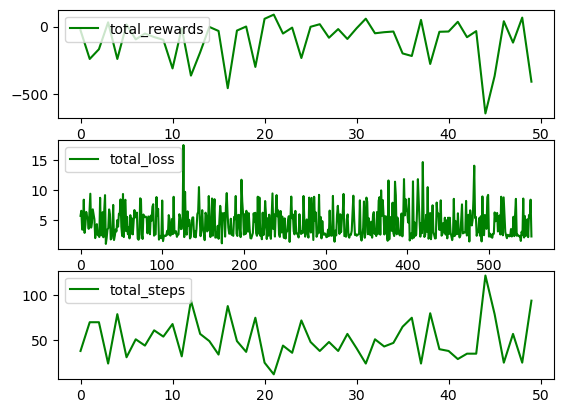

In [194]:
# hyper-parameters

NUM_COLOR = 3
MAX_LENGTH = 4
EMPTY = 2

EPSILON = 0.99

BATCH_SIZE = 32
MEMORY_CAPACITY = 2000
Q_NETWORK_ITERATION = 100

LR = 0.001
DELTA = 1.0
GAMMA = 0.90

EPISODES = 50

DEVICE = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dqn = DQN(NUM_COLOR, MAX_LENGTH, EMPTY, BATCH_SIZE, MEMORY_CAPACITY, Q_NETWORK_ITERATION, EPSILON, LR, DELTA, GAMMA, DEVICE)
reward_list, step_list, loss_list = dqn.train(EPISODES, True)

In [192]:
states = []
dqn.eval_net.eval()
with torch.no_grad():
    state, dfs_steps = dqn.env.reset()
    ep_reward = 0
    done = False
    while not done:
        states.append(copy.deepcopy(state))

        state = torch.FloatTensor(state).to(dqn.device)
        action, _ = dqn.choose_action(state, True)

        next_state, reward, done, info = dqn.env.step(action)
        ep_reward += reward
        state = next_state
ep_reward, info["steps"], dfs_steps

KeyboardInterrupt: 